## Challenge Questions
1. Find 5 most common journals;
1. Calculate mean, median, and standard deviation of open-access cost per article for each journal; and
1. Calculate open access prices per subject area.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import codecs
import string
from fuzzywuzzy import fuzz

C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
pd.set_option('display.max_rows', 5000)

In [3]:
p = 'H:/Documents/Training/Thinkful'
f = 'wellcome.csv'
encoding = 'ISO 8859-1'

## Cleaning Journal Titles
We want to reduce the variability of journal title representation. Variability is typically introduced through the following processes:
- Different letter case choices;
- Punctuation;
- White space;
- Spelling, including spelling errors; and
- Non-standard abbreviations.

The first issues I'll address are case choices and punctuation by converting all text to lowercase, stripping white space from the beginning and end of strings, and replacing multiple spaces in a row with a single space.

In [4]:
d = pd.read_csv('{path}/{file}'.format(path=p, file=f), encoding=encoding)
d = d.apply(lambda x: x.str.lower().str.strip().str.replace(r'\s+', ' '))
d.columns = pd.Series(d.columns).str.lower().apply(lambda x: re.sub(r'\s+|/+', '_', re.sub(r'\(.*', '', x).strip()))

d.columns

Index(['pmid_pmcid', 'publisher', 'journal_title', 'article_title', 'cost'], dtype='object')

### Cleaning journal titles
So far I haven't dealt with variation stemming from spelling or abbreviations. Since there there is a near infinite number of spelling and abbreviation variations, I'm not going to try to use a deterministic approach. Instead, I'm going to use fuzzy matching to help me identify like strings--specifically the token sort ratio. However, there is a problem I need to deal with first. The set ratio gives equal weight to all tokens when in fact not ever part of a journal title equally differentiates between journals. For example, we can see that two strings "Journal of Neuroscience" and "American Journal of Transplantation" represent different journals, mainly due to "neuroscience", "transplantation", and to a lesser extent "american" rather than "journal" and "of." I therefore created a dictionary of strings and replacement strings. Incidentally, just in this one normalization step we reduce the number of unique strings from 928 to 862.

In [5]:
repl = {
    r'the(?!rap)': '',
    r'(\b|^)(of|and|for|journal|j(nl)*)|jounral\b': '',
    r'plos\s*one': 'plos 1',
    '[{}]'.format(string.punctuation): ''
}

In [6]:
# Create the dataframe for mapping unique journal titles adjusted for case
ju = pd.DataFrame()
ju['records'] = d.journal_title.value_counts()
ju = ju.reset_index()
ju.columns = ['journal_title', 'records']

In [7]:
# First pass string normalization
temp = pd.Series(ju.journal_title.values)
for k, v in repl.items():
    temp = temp.str.replace(k, v)
    
ju['repl'] = temp.str.replace(r'\s+', ' ').str.strip()
ju['no_space'] = ju.repl.str.replace(r'\s+', '')

In [8]:
# merge pnas entries
ju['acronym'] = np.nan
ju.loc[~ju.no_space.apply(lambda x: re.search(r'pnas|(proceedings(?!(royal)))', x)).isna(), 'acronym'] = 'pnas'
ju.loc[ju.acronym.isna(), 'acronym'] = ju.no_space

In [9]:
# Sum records for newly adjusted merges
sm = ju[['acronym', 'records']].groupby('acronym').sum()
sm = sm.reset_index()
sm.columns = ('acronym', 'records')

# sm.sort_values('records', ascending=False).head(10)

I want to be able to map every transformed title back to their original form. So far I haven't changed any of the content, but I'm about to process strings a little more aggressively. Therefore, I'm creating a new dataframe that will store each successive transformation in a new column. This will help me debug if necessary.

### Fuzzy String Matching with fuzzywuzzy
At this point it's time to do the hard step of comparing strings for things like variable abbreviations. There's probably a better way to do this, but I created a matrix of set ratio values for each word pair. What I should have done was create a triangular matrix since the way I did the matching evaluates each word pair twice.

In [10]:
from fuzzywuzzy import fuzz

sym = sm.sort_values('records', ascending=False)
top = sym.head(10)
top = top.acronym
bottom_ind = np.setdiff1d(sym.index.values, top.index.values, assume_unique=True)
bottom = sym.iloc[bottom_ind]

In [11]:
fuz = pd.DataFrame()
fuz['acronym'] = bottom.acronym

for i in np.arange(0, len(top.index)):
    temp = bottom.acronym.apply(lambda x: fuzz.token_sort_ratio(x, top.iloc[i]))
    fuz[top.iloc[i]] = temp

In [12]:
# melt matrix to filter out low token sort ratio values 
fuzl = fuz.melt(id_vars='acronym', var_name='acronym2', value_name='sort_ratio')
fuzl = fuzl.loc[(fuzl.sort_ratio >= 85) & (fuzl.acronym > fuzl.acronym2)]\
    .sort_values('acronym').set_index(['acronym', 'acronym2'])

# Add the new value (in this case we arbitrarily choose the second value in value pairs)
fuzl = fuzl.assign(fuzzy = fuzl.index.levels[1].values).reset_index()

In [13]:
m = fuzl.melt(id_vars=['sort_ratio', 'fuzzy'], var_name='var', value_name='acronym')\
    .drop(['var', 'sort_ratio'], axis=1)

In [14]:
# Merge back into original table for final sums
fin = ju.merge(m, left_on='acronym', right_on='acronym', how='left').assign(final=np.nan)
fin.loc[fin.fuzzy.notna(), 'final'] = fin.fuzzy
fin.loc[fin.fuzzy.isna(), 'final'] = fin.acronym

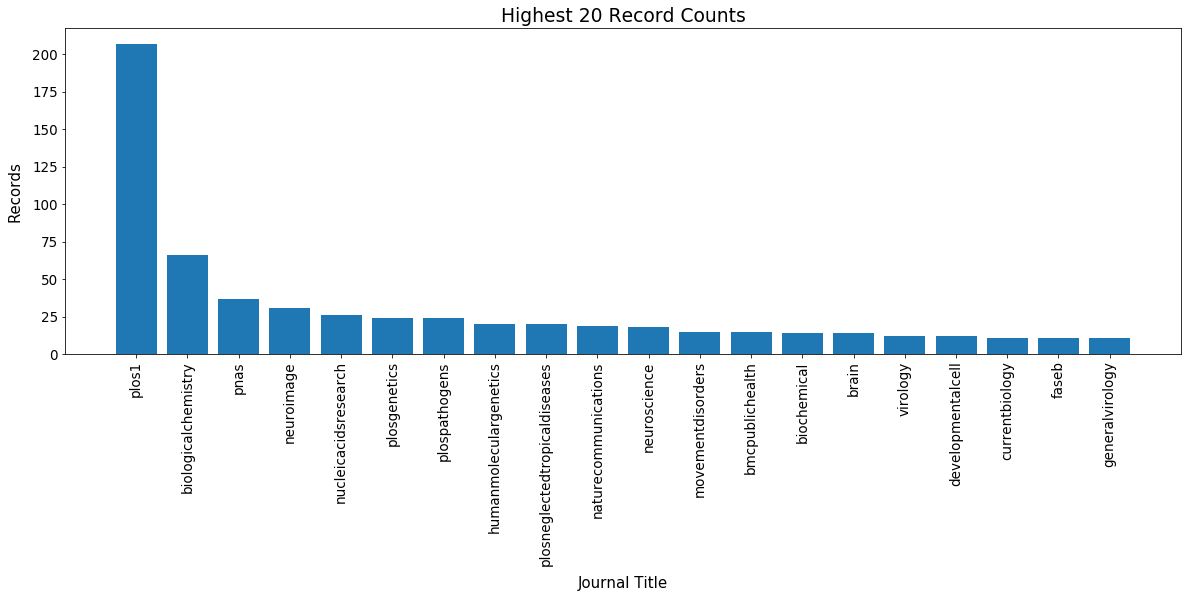

In [15]:
# Find top five journals
fin_counts = fin[['final', 'records']].groupby('final').sum().sort_values('records', ascending=False).reset_index()

# Plot formatting variables
fs = 15
tfs = fs*1.25
lpad = 10

fig, ax = plt.subplots(figsize=(20, 6))
ax.bar(fin_counts.final[0:20], fin_counts.records[0:20])
plt.title('Highest 20 Record Counts', fontsize=tfs)
plt.xticks(rotation=90, fontsize=fs*.9)
plt.yticks(fontsize=fs*0.9)
plt.xlabel('Journal Title', labelpad=lpad, fontsize=fs)
plt.ylabel('Records', fontsize=fs, labelpad=lpad)

plt.show()

### Top journals
The top five journals are PLoS 1 (207), Biological Chemistry (66), Proceedings of the National Academy of Science (PNAS, 37), Neuro Image (31), and Nucleic Acids Research (26). If this were an actual project where the answers mattered I would probably need to examine whether there were other entries that matched PLoS Genetics and PloS Pathogens, since they both had counts of 24 records respectively. 

In [24]:
fin_counts.head()

,final,records
0,plos1,207
1,biologicalchemistry,66
2,pnas,37
3,neuroimage,31
4,nucleicacidsresearch,26


## Question 2: Calculating the median, mean, and standard deviation
Before calculating the median, mean, and standard deviation I'll want to exclude inappropriate values, including:
- Values that appear to be coded. There are several values that are a string of nines, suggesting a signficance other than an actual article hosting price;
- Values that are not in pounds sterling. I noticed a few values with USD symbols. If any of those belong to the journals identified above they should be eliminated;
- Null values and zero length strings should also be eliminated since they are not necessarily equivalent to zero; and
- Any potential outliers.

In [25]:
cost = fin.loc[fin.final.isin(fin_counts.iloc[0:5]['final']), ['journal_title', 'final']]\
    .merge(d, left_on='journal_title', right_on='journal_title')
cost.dtypes

journal_title    object
final            object
pmid_pmcid       object
publisher        object
article_title    object
cost             object
dtype: object

### Testing for character values other than pound sterling and numeric, including periods and delimiters

In [27]:
try:
    cost['cost'] = cost.cost.str.replace(u'\u00a3', '').astype(float)
except Exception as e:
    print('It looks like you had more than just the one character.')
    print(e)

### Visualizing overall cost outliers

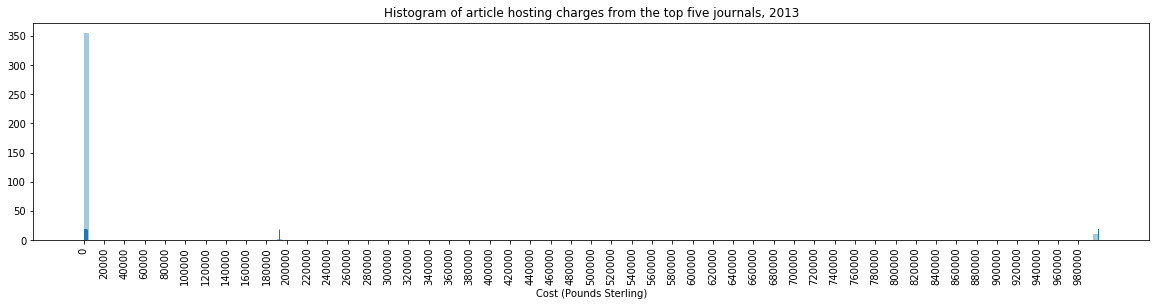

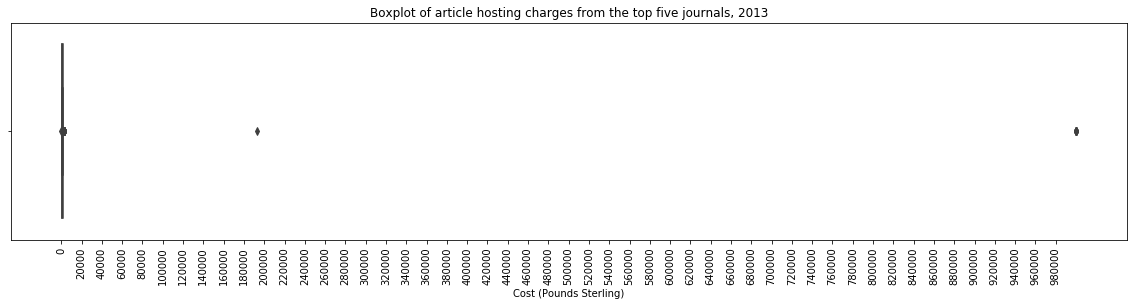

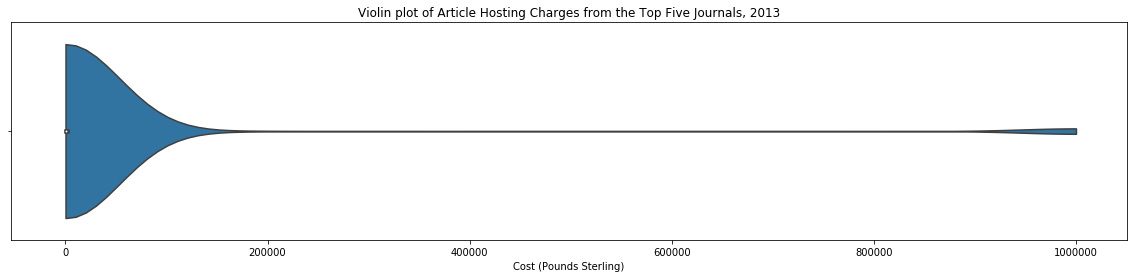

In [28]:
# -----------histogram
sns.distplot(cost.cost, bins=200, kde=False, rug=True)
fig=plt.gcf()
fig.set_size_inches(20, 4)
plt.xticks(np.arange(0, cost.cost.max(), 20000), rotation=90)
plt.title('Histogram of article hosting charges from the top five journals, 2013')
plt.xlabel('Cost (Pounds Sterling)')
plt.show()

# -----------boxplot
sns.boxplot('cost', data=cost, orient='h')
fig = plt.gcf().set_size_inches(20, 4)
plt.xticks(np.arange(0, cost.cost.max(), 20000), rotation=90)
plt.title('Boxplot of article hosting charges from the top five journals, 2013')
plt.xlabel('Cost (Pounds Sterling)')
plt.show()

# -----------violin plot
sns.violinplot('cost', data=cost, cut=0)
fig = plt.gcf().set_size_inches(20, 4)
plt.title('Violin plot of Article Hosting Charges from the Top Five Journals, 2013')
plt.xlabel('Cost (Pounds Sterling)')
plt.show()

### Visualizing non-outliers

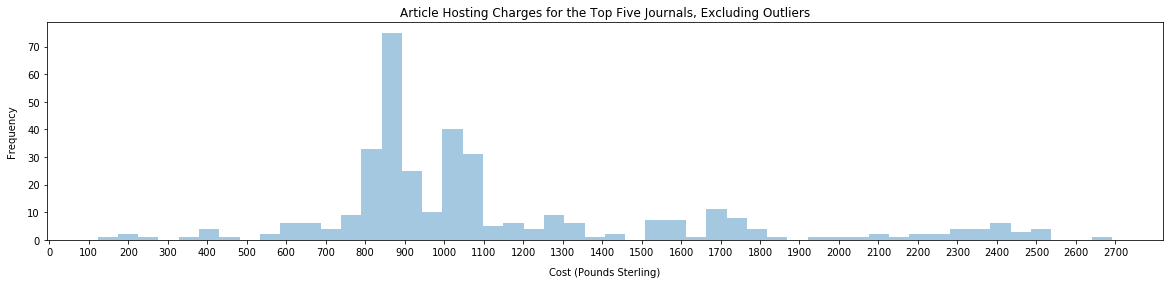

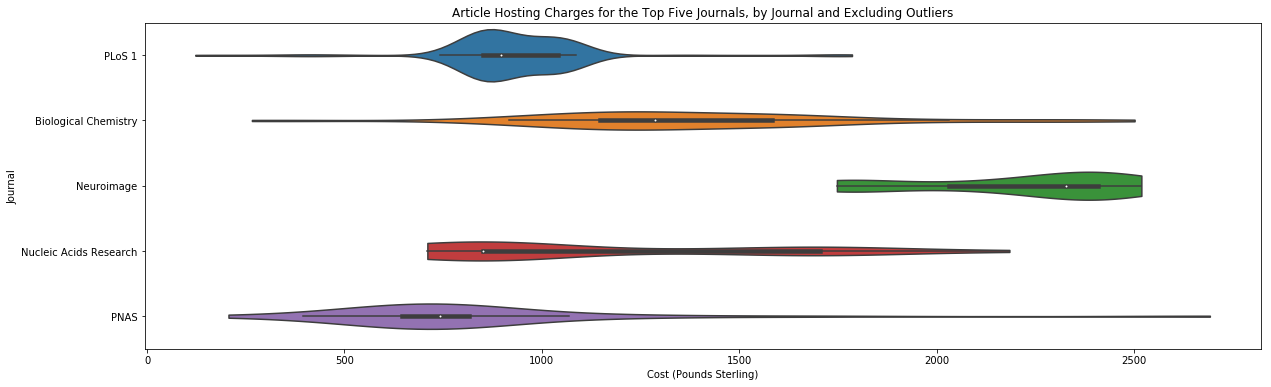

In [29]:
# -----------histogram < 10,000
h2 = cost.loc[cost.cost<10000]
sns.distplot(h2.cost, kde=False, rug=False, bins=50)
fig = plt.gcf()
fig.set_size_inches(20, 4)
plt.xticks(np.arange(0, h2.cost.max()+100, 100))
plt.title('Article Hosting Charges for the Top Five Journals, Excluding Outliers')
plt.xlabel('Cost (Pounds Sterling)', labelpad=10)
plt.ylabel('Frequency', labelpad=10)
plt.show()

# -----------Violin plot
sns.violinplot(data=h2, x='cost', y='final', cut=0)
fig = plt.gcf()
fig.set_size_inches(20, 6)
plt.yticks(np.arange(0, 5), labels=['PLoS 1', 'Biological Chemistry', 'Neuroimage', 'Nucleic Acids Research', 'PNAS'])
plt.title('Article Hosting Charges for the Top Five Journals, by Journal and Excluding Outliers')
plt.xlabel('Cost (Pounds Sterling)')
plt.ylabel('Journal')
plt.show()

### Median, Mean, and Standard Deviation for the Top Journals

In [37]:
h2[['final', 'cost']].groupby('final').agg(['median', 'mean', 'std'])

cost                         
                        median         mean         std
final                                                  
biologicalchemistry   1287.305  1376.870000  405.930082
neuroimage            2326.430  2212.181290  273.193244
nucleicacidsresearch   852.000  1149.000000  442.940447
plos1                  896.975   934.982121  194.966229
pnas                   742.920   817.041389  405.719904